In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

In [1]:
# images saved as BGR format
path = "G:\Meine Ablage\Images_AI_Project\zwiebel_jpg\zwiebel_6.jpg"
onion = cv2.imread(path.replace("\\","/"))

path = "G:\Meine Ablage\Images_AI_Project\karotte_jpg\karotte_2.jpg"
carrot = cv2.imread(path.replace("\\","/"))

path = "G:\Meine Ablage\Images_AI_Project\kartoffel_jpg\kartoffel_6.jpg"
potato = cv2.imread(path.replace("\\","/"))


NameError: name 'cv2' is not defined

In [6]:
path = "G:\Meine Ablage\Images_AI_Project\karotte_jpg"
carrot = plt.imread(path.replace("\\","/")+"/karotte_(221).jpg")
carrot.shape



(3024, 4032, 3)

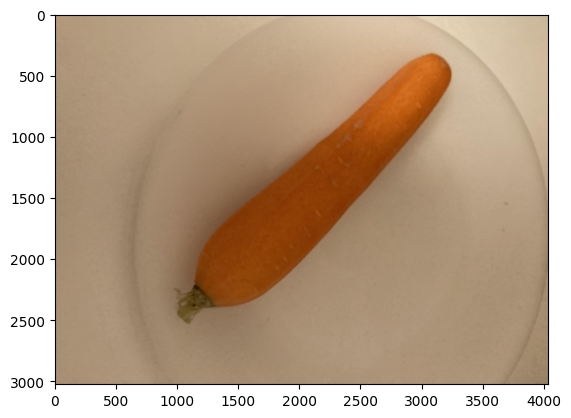

In [11]:
show_image_plt(carrot)

In [10]:
def show_image_plt(img):
    #rgb_carrot = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()

In [12]:
def show_image(img):
    cv2.imshow("Image", img)
    cv2.waitKey(0)
    

In [16]:
def resize_image(vegi):
    height, width, c = vegi.shape
    new_height = 100
    ratio = new_height / height 
    new_width = int(width * ratio)
    dimensions = (new_width, new_height)
    print(dimensions)
    resized_img = cv2.resize(vegi, dimensions, interpolation=cv2.INTER_LINEAR)
    print("New shape:      ", resized_img.shape)


    return resized_img

(133, 100)
New shape:       (100, 133, 3)
(100, 133, 3)
<class 'numpy.ndarray'>
39900


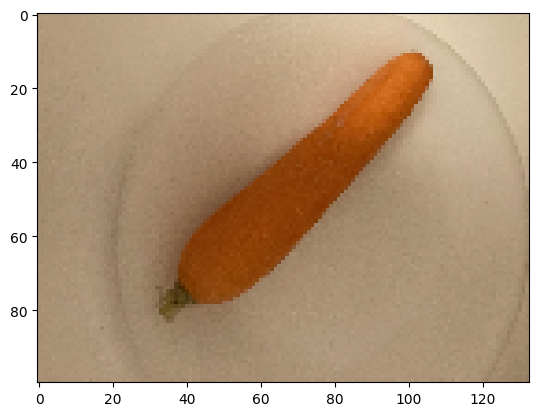

In [17]:

new_image = resize_image(carrot)
print(new_image.shape)
print(type(new_image))
print(new_image.size)
show_image_plt(new_image)

